In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

### Importing Preprocessed Excel file worked in Tasca 5

Preprocessed Dataset = Vuelos sin cancelaciones y sin NA's

In [3]:
data = pd.read_csv('delayed_flights_preprocessed.csv', ',')

In [4]:
data.head()

,Date,DayOfWeek,FlightNum,FullCarrier,Origin,FullOrigin,Dest,FullDest,Cancelled,Delayed,DoubleDelay,5%_Delayed,ArrDelay,CRSElapsedTime,DepDelay,ArrTime,DepTime,AirTime,Distance,AvgSpeed
0,2008-01-01,2,1239,United Air Lines Inc.,PDX,Portland Intl,LAX,Los Angeles International,0,yes,yes,yes,16.0,136.0,13.0,21:11,18:52,116.0,834,431.38
1,2008-01-01,2,1659,Continental Air Lines Inc.,IAH,George Bush Intercontinental,DFW,Dallas-Fort Worth International,0,yes,yes,no,2.0,70.0,6.0,19:02,17:56,43.0,224,312.56
2,2008-01-01,2,5621,Comair Inc.,ATL,William B Hartsfield-Atlanta Intl,BTR,"Baton Rouge Metropolitan, Ryan",0,yes,yes,yes,42.0,107.0,52.0,10:57,10:20,78.0,449,345.38
3,2008-01-01,2,5630,Comair Inc.,CVG,Cincinnati Northern Kentucky Intl,CID,Eastern Iowa,0,yes,yes,yes,27.0,90.0,15.0,15:12,14:30,73.0,419,344.38
4,2008-01-01,2,597,American Airlines Inc.,ORD,Chicago O'Hare International,SAT,San Antonio International,0,yes,yes,yes,43.0,180.0,72.0,22:43,20:12,130.0,1041,480.46


### Eliminando variables que no se usarán

In [5]:
columns_to_drop = ['FlightNum', 'FullOrigin', 'FullDest', 'Delayed', 'DoubleDelay', '5%_Delayed']
data.drop(['FlightNum', 'FullOrigin', 'FullDest', 'Delayed', 'DoubleDelay', '5%_Delayed', 'Date'], axis=1, inplace=True)

In [6]:
data

,DayOfWeek,FullCarrier,Origin,Dest,Cancelled,ArrDelay,CRSElapsedTime,DepDelay,ArrTime,DepTime,AirTime,Distance,AvgSpeed
0,2,United Air Lines Inc.,PDX,LAX,0,16.0,136.0,13.0,21:11,18:52,116.0,834,431.38
1,2,Continental Air Lines Inc.,IAH,DFW,0,2.0,70.0,6.0,19:02,17:56,43.0,224,312.56
2,2,Comair Inc.,ATL,BTR,0,42.0,107.0,52.0,10:57,10:20,78.0,449,345.38
3,2,Comair Inc.,CVG,CID,0,27.0,90.0,15.0,15:12,14:30,73.0,419,344.38
4,2,American Airlines Inc.,ORD,SAT,0,43.0,180.0,72.0,22:43,20:12,130.0,1041,480.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936753,3,JetBlue Airways,EWR,RSW,0,100.0,192.0,98.0,12:57,09:43,165.0,1068,388.36
1936754,3,JetBlue Airways,EWR,MCO,0,7.0,167.0,22.0,23:34,21:02,133.0,938,423.16
1936755,3,JetBlue Airways,EWR,MCO,0,6.0,172.0,7.0,21:53,19:02,132.0,938,426.36
1936756,3,JetBlue Airways,EWR,FLL,0,34.0,177.0,43.0,00:56,22:08,144.0,1065,443.75


### Eliminación de NA's

Como ya se abordó el tratamiento de NA's previamente, se opta por simplemente eliminarlos por representar una proporción muy baja de la muestra (0,4%)

In [7]:
pd.DataFrame({'unicos':data.nunique(),
              'missing': round(data.isna().sum()/data.count(), 3),
              'tipo':data.dtypes})

,unicos,missing,tipo
DayOfWeek,7,0.000,int64
FullCarrier,20,0.000,object
Origin,303,0.000,object
Dest,304,0.000,object
Cancelled,2,0.000,int64
ArrDelay,1128,0.004,float64
CRSElapsedTime,515,0.000,float64
DepDelay,1058,0.000,float64
ArrTime,1441,0.000,object
DepTime,1438,0.000,object


In [8]:
data = data.dropna(axis=0)

In [9]:
data.shape

(1928371, 13)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1928371 entries, 0 to 1936756
Data columns (total 13 columns):
DayOfWeek         int64
FullCarrier       object
Origin            object
Dest              object
Cancelled         int64
ArrDelay          float64
CRSElapsedTime    float64
DepDelay          float64
ArrTime           object
DepTime           object
AirTime           float64
Distance          int64
AvgSpeed          float64
dtypes: float64(5), int64(3), object(5)
memory usage: 206.0+ MB


### Creación de variable "10%_Delay" (ArrDelay > CRSElapsedTime*0,1) --> Variable a predecir

Esta variable clasifica a un vuelo como "demorado" siempre y cuando la demora de llegada sea mayor al 10% de la duración estimada del vuelo

In [11]:
data['10%_Delayed'] = np.where(data['ArrDelay']>data['CRSElapsedTime']*0.1,1,0)

C:\Users\tomi_\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Creación de variable "ArrDelay_vs_CRSElapsedTime"

La creación de esta variable va a ser útil para posteriormente efectuar visualizaciones gráficas. 

In [12]:
data['ArrDelay_vs_CRSElapsedTime'] = round((data['ArrDelay']/data['CRSElapsedTime']), 3)

C:\Users\tomi_\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Reemplazo de Nombre de Carrier existente para facilitar lectura

In [13]:
data.loc[data['FullCarrier']=='US Airways Inc. (Merged with America West 9/05. Reporting for both starting 10/07.)', 'FullCarrier'] = 'US Airways Inc.'

C:\Users\tomi_\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1928371 entries, 0 to 1936756
Data columns (total 15 columns):
DayOfWeek                     int64
FullCarrier                   object
Origin                        object
Dest                          object
Cancelled                     int64
ArrDelay                      float64
CRSElapsedTime                float64
DepDelay                      float64
ArrTime                       object
DepTime                       object
AirTime                       float64
Distance                      int64
AvgSpeed                      float64
10%_Delayed                   int32
ArrDelay_vs_CRSElapsedTime    float64
dtypes: float64(6), int32(1), int64(3), object(5)
memory usage: 228.0+ MB


# EJERCICIO 1

### Particionar en Train & Test y estudiar ambos conjuntos de manera descriptiva y por separado

#### Dividiendo entre Train & Test con un muestreo aleatorio simple y con una partición 80/20 entre train y test respectivamente

In [15]:
train, test = train_test_split(data, test_size = 0.2, random_state=42)

## EDA Train set

In [16]:
train.shape

(1542696, 15)

In [17]:
train.describe()

,DayOfWeek,Cancelled,ArrDelay,CRSElapsedTime,DepDelay,AirTime,Distance,AvgSpeed,10%_Delayed,ArrDelay_vs_CRSElapsedTime
count,1.542696e+06,1542696.0,1.542696e+06,1.542696e+06,1.542696e+06,1.542696e+06,1.542696e+06,1542696.00,1.542696e+06,1.542696e+06
mean,3.984534e+00,0.0,4.218236e+01,1.342105e+02,4.308197e+01,1.082859e+02,7.650975e+02,inf,6.835961e-01,4.005862e-01
std,1.996393e+00,0.0,5.677646e+01,7.120856e+01,5.325858e+01,6.860921e+01,5.737244e+02,NaN,4.650727e-01,6.302559e-01
min,1.000000e+00,0.0,-1.090000e+02,-2.100000e+01,6.000000e+00,0.000000e+00,1.100000e+01,21.29,0.000000e+00,-4.524000e+00
25%,2.000000e+00,0.0,9.000000e+00,8.200000e+01,1.200000e+01,5.800000e+01,3.380000e+02,351.91,0.000000e+00,7.000000e-02
50%,4.000000e+00,0.0,2.400000e+01,1.160000e+02,2.400000e+01,9.000000e+01,6.060000e+02,403.88,1.000000e+00,2.090000e-01
75%,6.000000e+00,0.0,5.600000e+01,1.650000e+02,5.300000e+01,1.370000e+02,9.980000e+02,448.18,1.000000e+00,5.000000e-01
max,7.000000e+00,0.0,2.453000e+03,6.600000e+02,2.467000e+03,1.091000e+03,4.962000e+03,inf,1.000000e+00,2.440000e+02


### Expresión gráfica de correlación entre variables

In [18]:
#numerical_data = train[['DayOfWeek', 'Cancelled', 'ArrDelay', 'DepDelay', 'AirTime', 'CRSElapsedTime', 'Distance', 'AvgSpeed', 'ArrDelay_vs_CRSElapsedTime']]

#sns.pairplot(numerical_data, diag_kind='kde', plot_kws={'alpha': 0.2})

### Visualización proporción %10_delayed

Más del 30% de los vuelos conllevó una demora de al menos 10% respecto a la duración estimada del vuelo

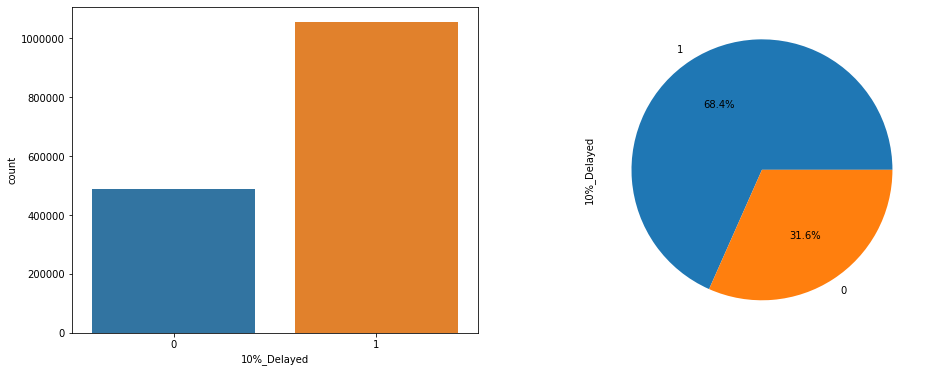

In [19]:
f, ax = plt.subplots(1, 2, figsize=[16, 6])
sns.countplot('10%_Delayed', data=train, ax=ax[0])
train['10%_Delayed'].value_counts().plot(kind='pie', ax=ax[1], autopct='%1.1f%%')
plt.show()

### Top 5 Carriers con mayor cantidad de Vuelos

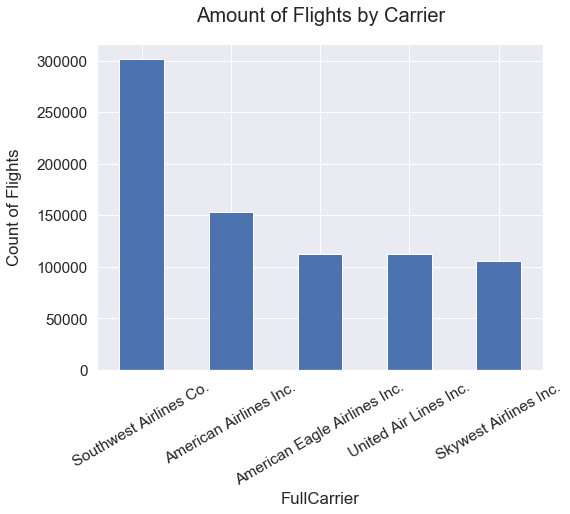

In [20]:
sns.set(font_scale=1.4)
train.groupby('FullCarrier')['DayOfWeek'].count().sort_values(ascending=False).head(5).plot(kind='bar', figsize=(8, 6), rot=30)
plt.ylabel("Count of Flights", labelpad=14)
plt.title("Amount of Flights by Carrier", y=1.05, size=20);

### Top 5 Carriers con mayor ratio de Demora / Vuelos

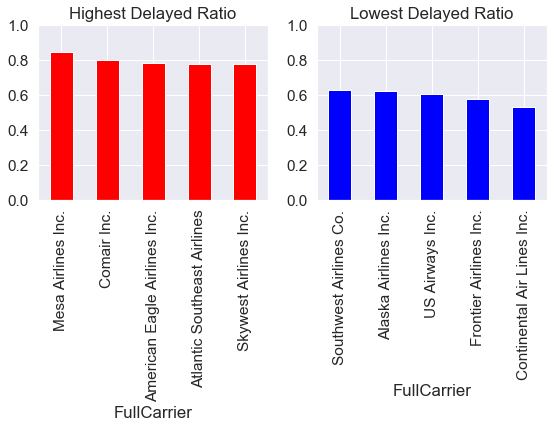

In [21]:
sns.set(font_scale=1.4)
f, ax = plt.subplots(1, 2, figsize=[25, 10])
round((train[train['10%_Delayed'] == 1].groupby('FullCarrier').count()['10%_Delayed']/train.groupby('FullCarrier').count()['10%_Delayed']).sort_values(ascending=False),3).head(5).plot(kind='bar', figsize=(8, 6), ax=ax[0], color='red')
round((train[train['10%_Delayed'] == 1].groupby('FullCarrier').count()['10%_Delayed']/train.groupby('FullCarrier').count()['10%_Delayed']).sort_values(ascending=False),3).tail(5).plot(kind='bar', figsize=(8, 6), ax=ax[1], color='blue')

f.tight_layout()
ax[0].set_title('Highest Delayed Ratio')
ax[1].set_title('Lowest Delayed Ratio')
ax[0].set_ylim(0, 1)
ax[1].set_ylim(0, 1)
plt.show()

### Análisis por Day of Week

In [22]:
train.groupby('DayOfWeek').describe()['10%_Delayed']

,count,mean,std,min,25%,50%,75%,max
DayOfWeek,,,,,,,,
1,231896.0,0.682797,0.465388,0.0,0.0,1.0,1.0,1.0
2,207950.0,0.688666,0.463040,0.0,0.0,1.0,1.0,1.0
3,209207.0,0.679117,0.466817,0.0,0.0,1.0,1.0,1.0
4,230526.0,0.685784,0.464204,0.0,0.0,1.0,1.0,1.0
5,257433.0,0.704611,0.456219,0.0,0.0,1.0,1.0,1.0
6,177550.0,0.646336,0.478108,0.0,0.0,1.0,1.0,1.0
7,228134.0,0.686969,0.463728,0.0,0.0,1.0,1.0,1.0


VUELOS Y VUELOS DEMORADOS:

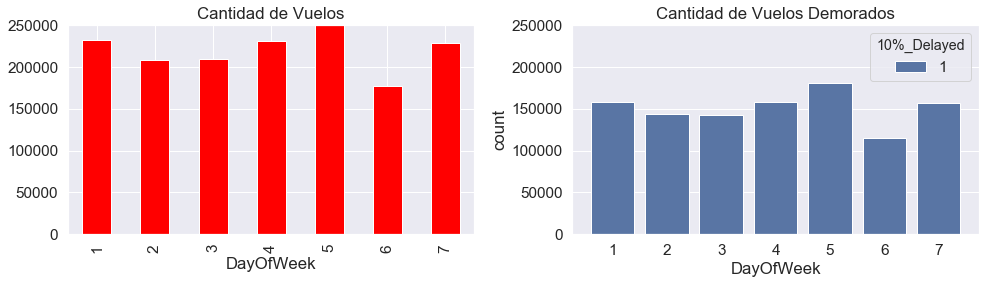

In [23]:
f, ax = plt.subplots(1, 2, figsize=[45, 20])
train.groupby('DayOfWeek')['FullCarrier'].count().plot(kind='bar', figsize=(14, 4), ax=ax[0], color='red')
sns.countplot('DayOfWeek', data=train.loc[train['10%_Delayed']==1], hue='10%_Delayed').plot(kind='bar', figsize=(8, 6), ax=ax[1], color='blue')

f.tight_layout()
ax[0].set_title('Cantidad de Vuelos')
ax[1].set_title('Cantidad de Vuelos Demorados')
ax[0].set_ylim(0, 250000)
ax[1].set_ylim(0, 250000)
plt.show()

C:\Users\tomi_\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


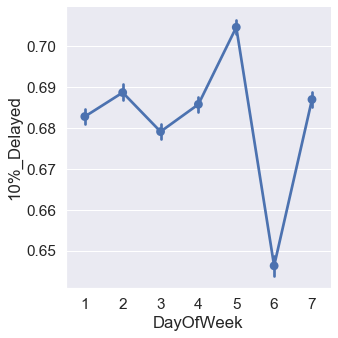

In [24]:
sns.factorplot('DayOfWeek', '10%_Delayed', data=train, figsize=(16, 6))

### Ratio of 10%_Delayed by Carrier and by Day of the Week

ANEXAR A MISMO GRAFICO, BARRAS QUE INDIQUEN CANTIDAD DE VUELOS (TODAS CON MISMA ESCALA) EN EJE SECUNDARIO

C:\Users\tomi_\Anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


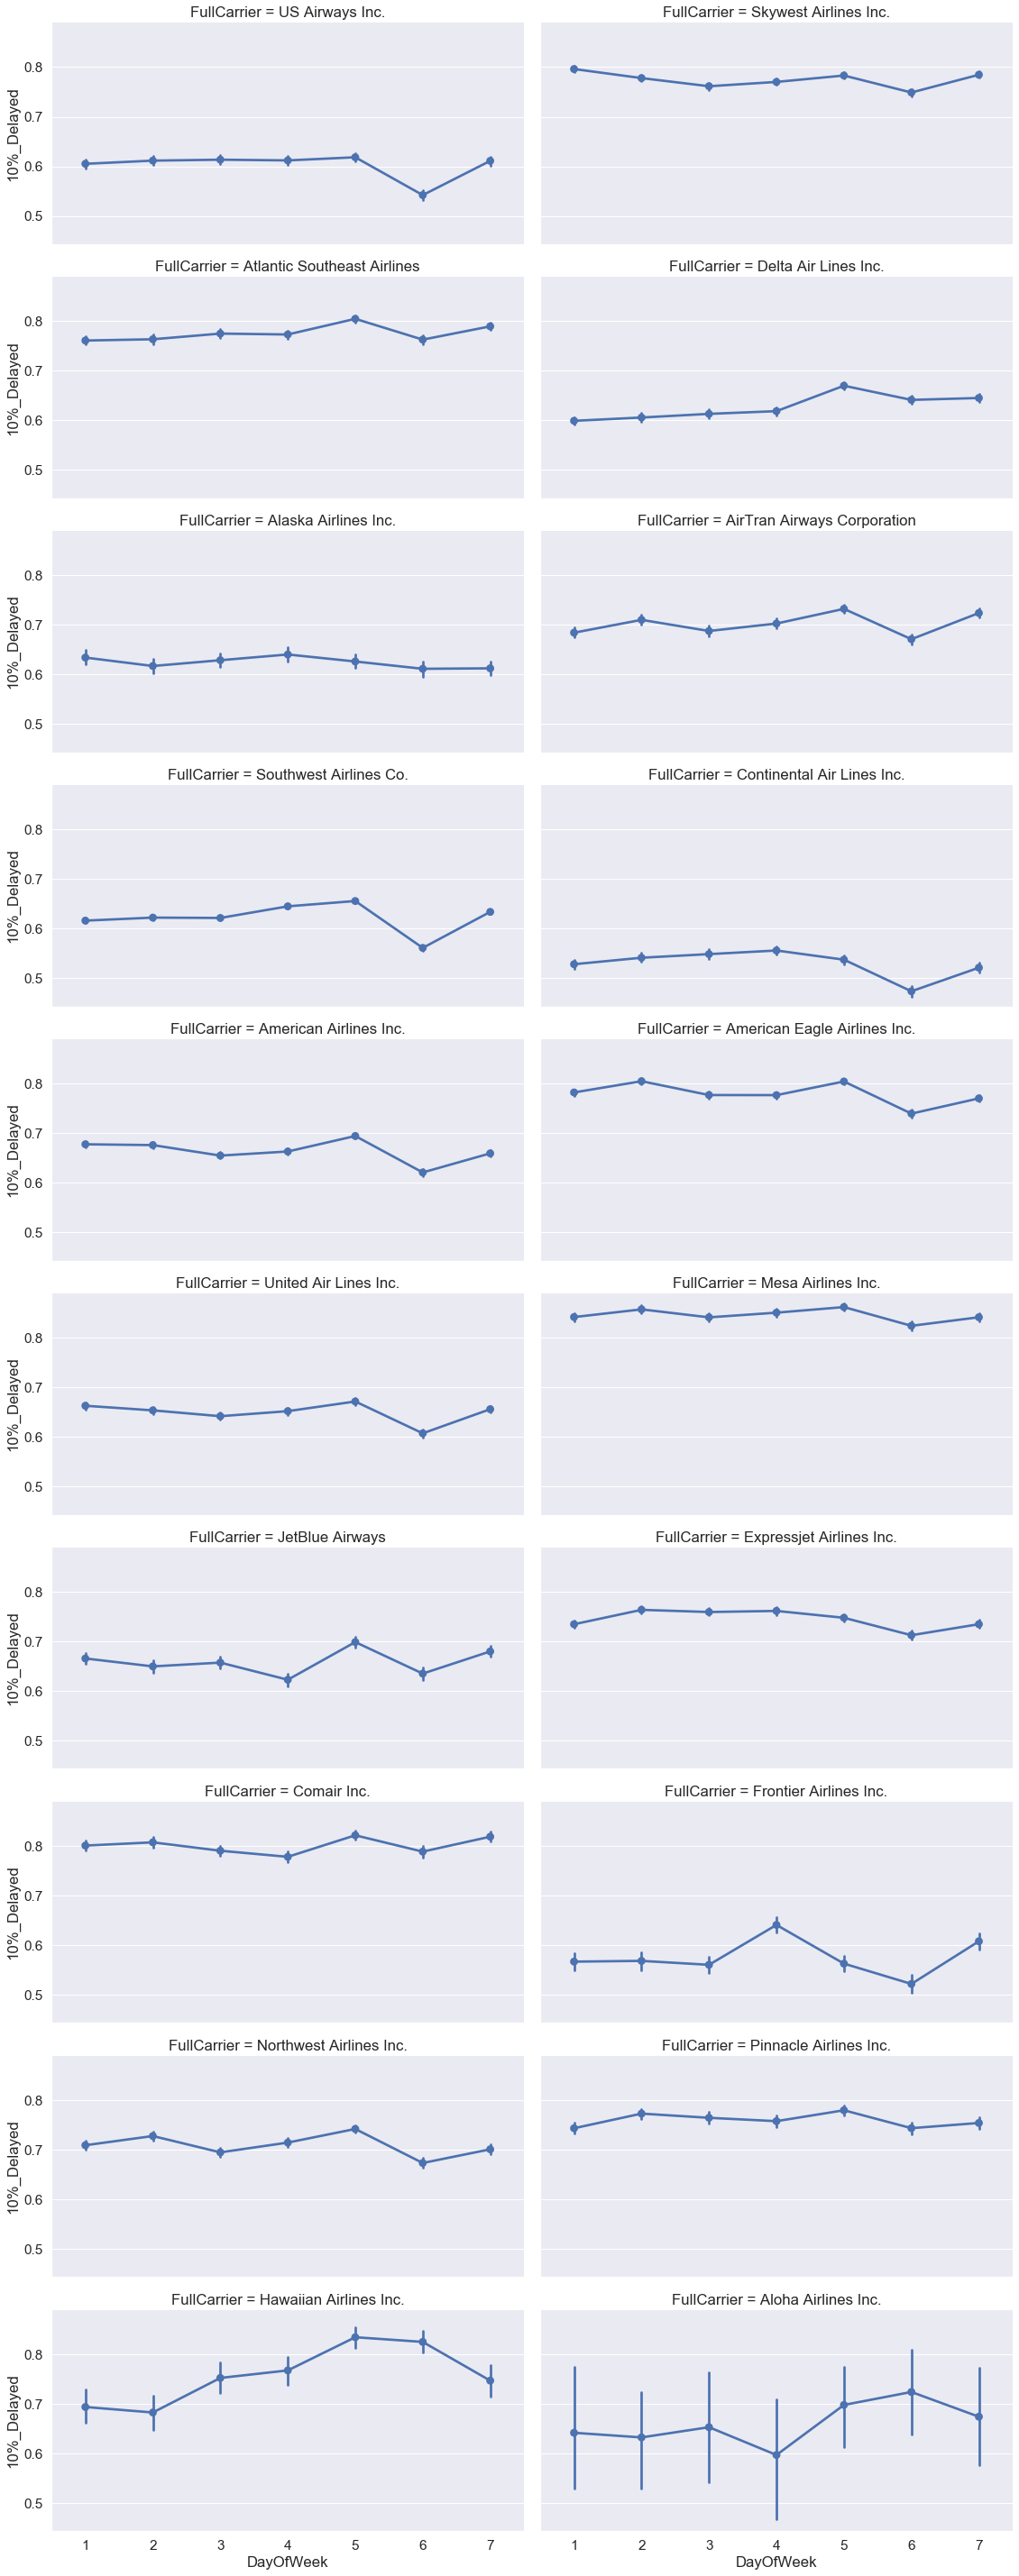

In [25]:
sns.factorplot('DayOfWeek', '10%_Delayed', data=train, col='FullCarrier', col_wrap=2, size=4, aspect=2)

### Eficiencia de aerolíneas: promedio de minutos demorados respecto a tiempo estimado de vuelo

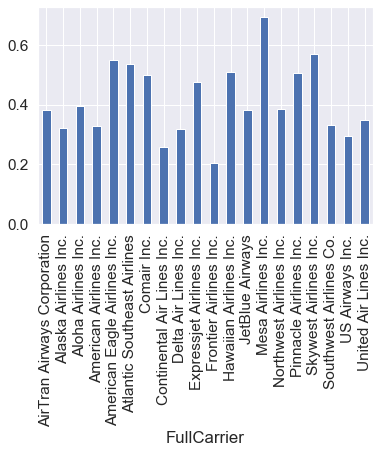

In [26]:
train.groupby('FullCarrier').mean()['ArrDelay_vs_CRSElapsedTime'].plot(kind='bar')

### Procedencia y Destino

VUELOS

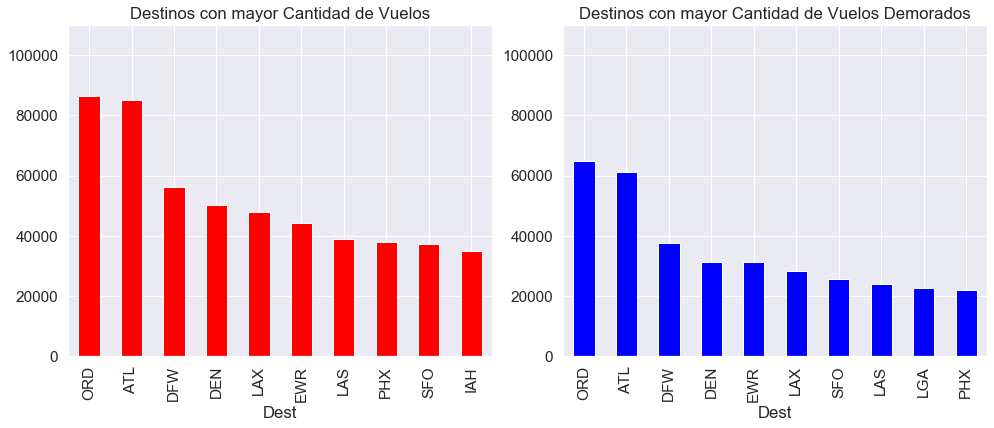

In [27]:
f, ax = plt.subplots(1, 2, figsize=[45, 45])

train.groupby('Dest')['FullCarrier'].count().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(14, 6), ax=ax[0], color='red')
train.loc[train['10%_Delayed']==1].groupby('Dest')['FullCarrier'].count().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(14, 6), ax=ax[1], color='blue')


f.tight_layout()
ax[0].set_title('Destinos con mayor Cantidad de Vuelos')
ax[1].set_title('Destinos con mayor Cantidad de Vuelos Demorados')
ax[0].set_ylim(0, 110000)
ax[1].set_ylim(0, 110000)

plt.show()

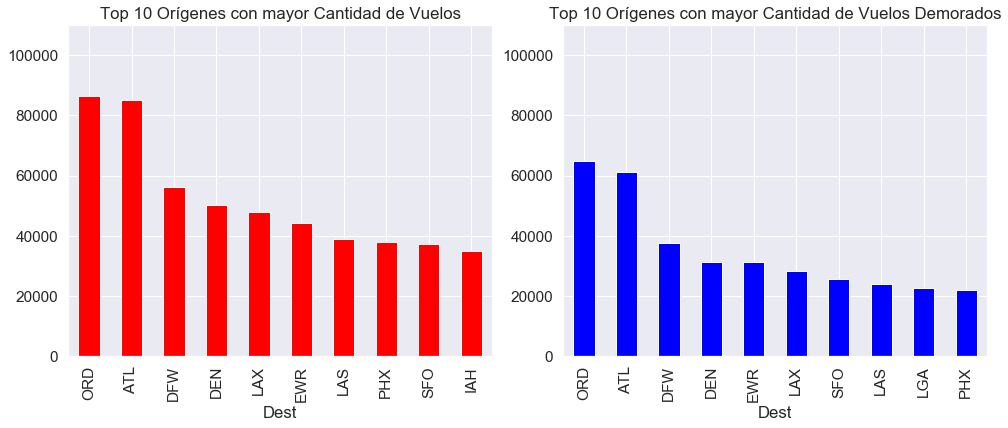

In [28]:
f, ax = plt.subplots(1, 2, figsize=[45, 45])

train.groupby('Dest')['FullCarrier'].count().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(14, 6), ax=ax[0], color='red')
train.loc[train['10%_Delayed']==1].groupby('Dest')['FullCarrier'].count().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(14, 6), ax=ax[1], color='blue')


f.tight_layout()
ax[0].set_title('Top 10 Orígenes con mayor Cantidad de Vuelos')
ax[1].set_title('Top 10 Orígenes con mayor Cantidad de Vuelos Demorados')
ax[0].set_ylim(0, 110000)
ax[1].set_ylim(0, 110000)

plt.show()

## EDA Test Set

In [29]:
test.shape

(385675, 15)

In [30]:
test.describe()

,DayOfWeek,Cancelled,ArrDelay,CRSElapsedTime,DepDelay,AirTime,Distance,AvgSpeed,10%_Delayed,ArrDelay_vs_CRSElapsedTime
count,385675.000000,385675.0,385675.000000,385675.000000,385675.000000,385675.000000,385675.000000,385675.000,385675.000000,385675.000000
mean,3.986859,0.0,42.269971,134.146310,43.130597,108.242199,764.352794,inf,0.684291,0.401165
std,1.994681,0.0,56.817738,71.332666,53.295715,68.776115,574.530953,NaN,0.464798,0.601519
min,1.000000,0.0,-57.000000,2.000000,6.000000,0.000000,11.000000,33.180,0.000000,-0.400000
25%,2.000000,0.0,9.000000,82.000000,12.000000,58.000000,338.000000,351.795,0.000000,0.071000
50%,4.000000,0.0,25.000000,116.000000,24.000000,90.000000,606.000000,403.640,1.000000,0.210000
75%,6.000000,0.0,56.000000,165.000000,53.000000,137.000000,994.000000,447.930,1.000000,0.504000
max,7.000000,0.0,2461.000000,660.000000,2457.000000,733.000000,4962.000000,inf,1.000000,42.500000


### Expresión gráfica de correlación entre variables

In [31]:
#numerical_data_test = test[['DayOfWeek', 'Cancelled', 'ArrDelay', 'DepDelay', 'AirTime', 'CRSElapsedTime', 'Distance', 'AvgSpeed', 'ArrDelay_vs_CRSElapsedTime']]

#sns.pairplot(numerical_data_test, diag_kind='kde', plot_kws={'alpha': 0.2})

### Visualización proporción %10_delayed

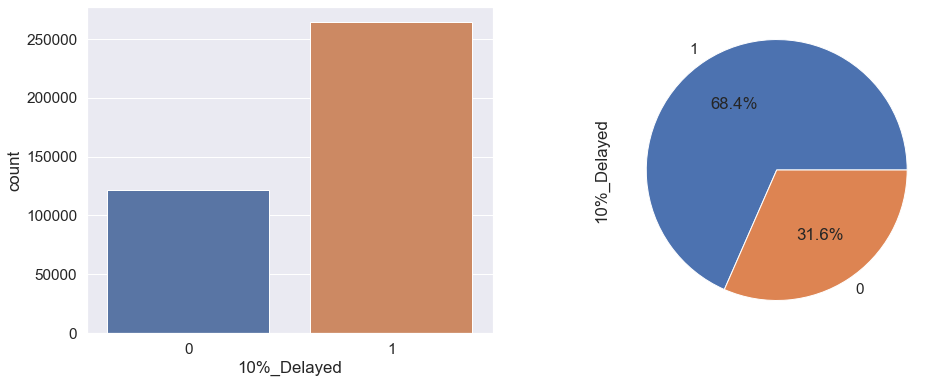

In [32]:
f, ax = plt.subplots(1, 2, figsize=[16, 6])
sns.countplot('10%_Delayed', data=test, ax=ax[0])
test['10%_Delayed'].value_counts().plot(kind='pie', ax=ax[1], autopct='%1.1f%%')
plt.show()

### Top 5 Carriers con mayor cantidad de Vuelos

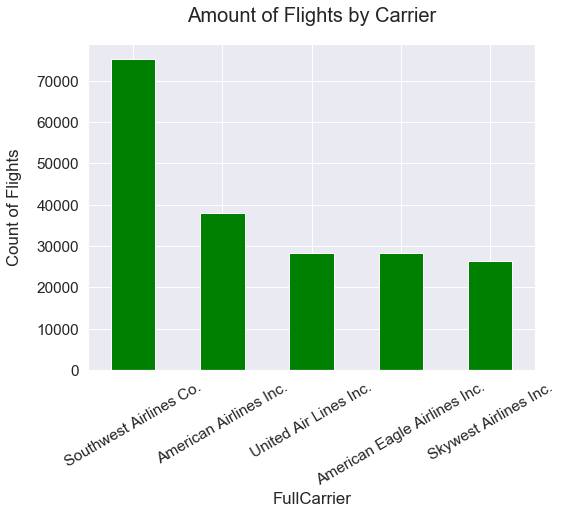

In [33]:
sns.set(font_scale=1.4)
test.groupby('FullCarrier')['DayOfWeek'].count().sort_values(ascending=False).head(5).plot(kind='bar', figsize=(8, 6), rot=30, color='green')
plt.ylabel("Count of Flights", labelpad=14)
plt.title("Amount of Flights by Carrier", y=1.05, size=20);

### Top 5 Carriers con mayor ratio de Demora / Vuelos

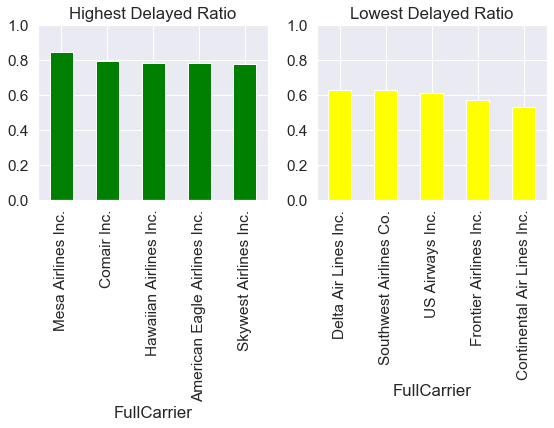

In [34]:
sns.set(font_scale=1.4)
f, ax = plt.subplots(1, 2, figsize=[25, 10])
round((test[test['10%_Delayed'] == 1].groupby('FullCarrier').count()['10%_Delayed']/test.groupby('FullCarrier').count()['10%_Delayed']).sort_values(ascending=False),3).head(5).plot(kind='bar', figsize=(8, 6), ax=ax[0], color='green')
round((test[test['10%_Delayed'] == 1].groupby('FullCarrier').count()['10%_Delayed']/test.groupby('FullCarrier').count()['10%_Delayed']).sort_values(ascending=False),3).tail(5).plot(kind='bar', figsize=(8, 6), ax=ax[1], color='yellow')

f.tight_layout()
ax[0].set_title('Highest Delayed Ratio')
ax[1].set_title('Lowest Delayed Ratio')
ax[0].set_ylim(0, 1)
ax[1].set_ylim(0, 1)
plt.show()

### Análisis por Day of Week

In [35]:
test.groupby('DayOfWeek').describe()['10%_Delayed']

,count,mean,std,min,25%,50%,75%,max
DayOfWeek,,,,,,,,
1,57926.0,0.683389,0.465158,0.0,0.0,1.0,1.0,1.0
2,51634.0,0.689507,0.462700,0.0,0.0,1.0,1.0,1.0
3,52291.0,0.677574,0.467410,0.0,0.0,1.0,1.0,1.0
4,57818.0,0.688350,0.463172,0.0,0.0,1.0,1.0,1.0
5,64549.0,0.705418,0.455858,0.0,0.0,1.0,1.0,1.0
6,44651.0,0.643502,0.478970,0.0,0.0,1.0,1.0,1.0
7,56806.0,0.690578,0.462259,0.0,0.0,1.0,1.0,1.0


VUELOS Y VUELOS DEMORADOS:

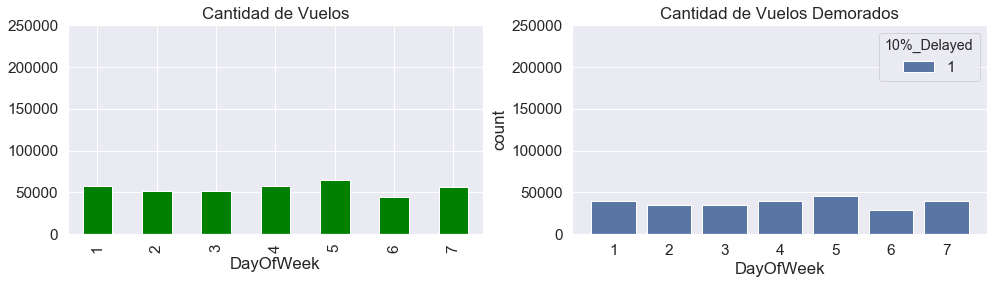

In [36]:
f, ax = plt.subplots(1, 2, figsize=[45, 20])
test.groupby('DayOfWeek')['FullCarrier'].count().plot(kind='bar', figsize=(14, 4), ax=ax[0], color='green')
sns.countplot('DayOfWeek', data=test.loc[test['10%_Delayed']==1], hue='10%_Delayed').plot(kind='bar', figsize=(8, 6), ax=ax[1], color='yellow')

f.tight_layout()
ax[0].set_title('Cantidad de Vuelos')
ax[1].set_title('Cantidad de Vuelos Demorados')
ax[0].set_ylim(0, 250000)
ax[1].set_ylim(0, 250000)
plt.show()

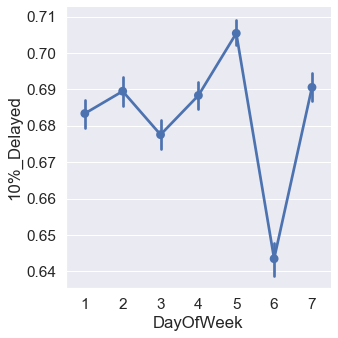

In [37]:
sns.factorplot('DayOfWeek', '10%_Delayed', data=test, figsize=(16, 6))

### Ratio of 10%_Delayed by Carrier and by Day of the Week

ANEXAR A MISMO GRAFICO, BARRAS QUE INDIQUEN CANTIDAD DE VUELOS (TODAS CON MISMA ESCALA) EN EJE SECUNDARIO

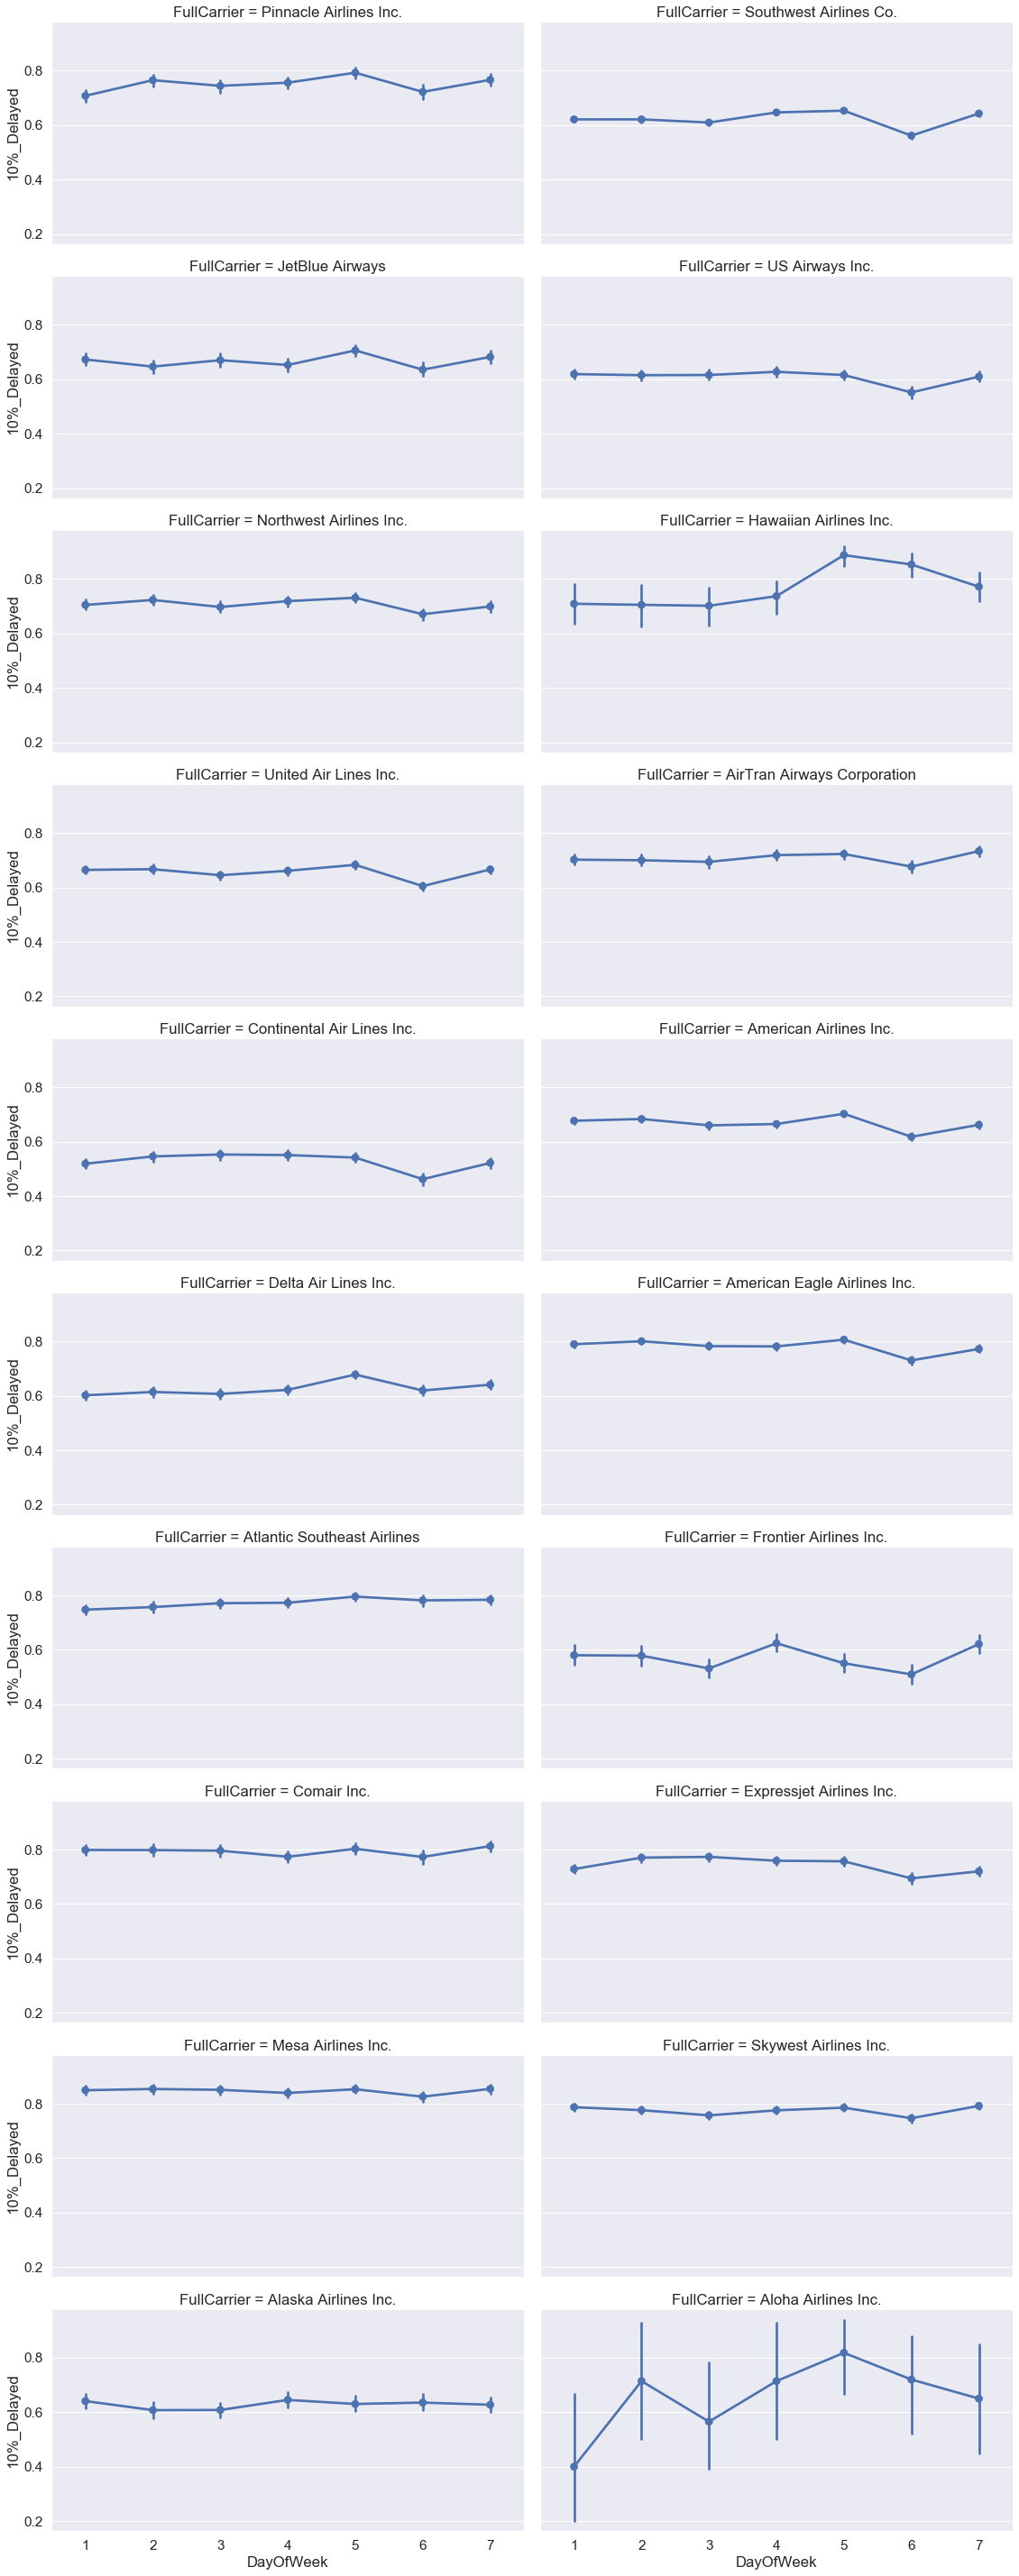

In [38]:
sns.factorplot('DayOfWeek', '10%_Delayed', data=test, col='FullCarrier', col_wrap=2, size=4, aspect=2)

### Eficiencia de aerolíneas: promedio de minutos demorados respecto a tiempo estimado de vuelo

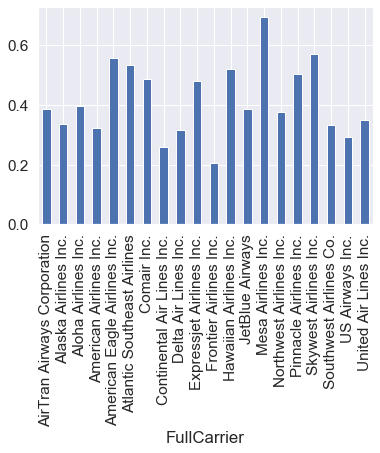

In [39]:
test.groupby('FullCarrier').mean()['ArrDelay_vs_CRSElapsedTime'].plot(kind='bar')

### Procedencia y Destino

VUELOS

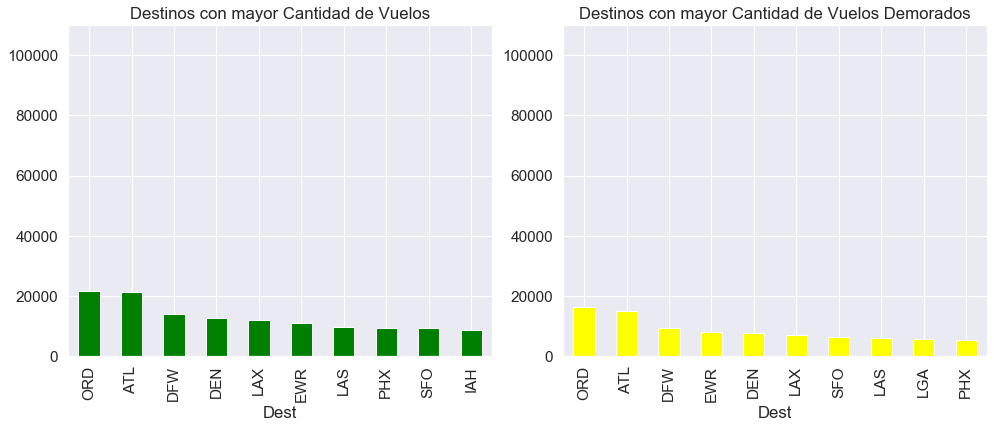

In [40]:
f, ax = plt.subplots(1, 2, figsize=[45, 45])

test.groupby('Dest')['FullCarrier'].count().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(14, 6), ax=ax[0], color='green')
test.loc[test['10%_Delayed']==1].groupby('Dest')['FullCarrier'].count().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(14, 6), ax=ax[1], color='yellow')


f.tight_layout()
ax[0].set_title('Destinos con mayor Cantidad de Vuelos')
ax[1].set_title('Destinos con mayor Cantidad de Vuelos Demorados')
ax[0].set_ylim(0, 110000)
ax[1].set_ylim(0, 110000)

plt.show()

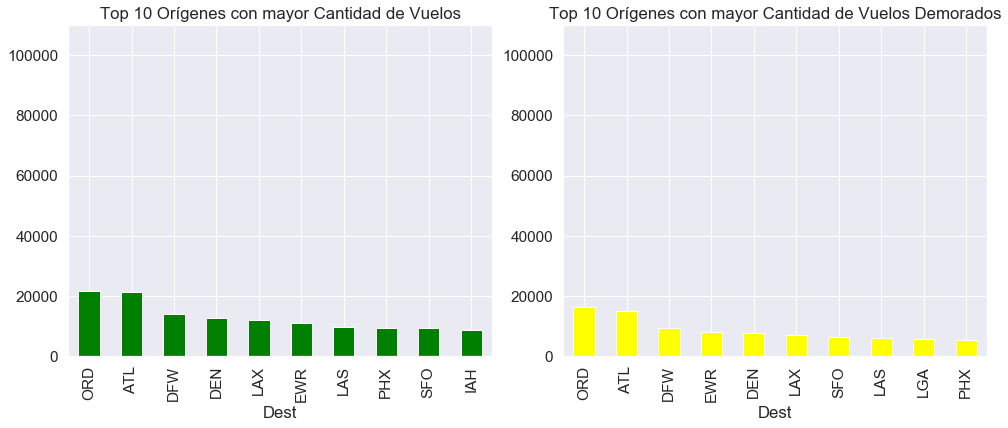

In [41]:
f, ax = plt.subplots(1, 2, figsize=[45, 45])

test.groupby('Dest')['FullCarrier'].count().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(14, 6), ax=ax[0], color='green')
test.loc[test['10%_Delayed']==1].groupby('Dest')['FullCarrier'].count().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(14, 6), ax=ax[1], color='yellow')


f.tight_layout()
ax[0].set_title('Top 10 Orígenes con mayor Cantidad de Vuelos')
ax[1].set_title('Top 10 Orígenes con mayor Cantidad de Vuelos Demorados')
ax[0].set_ylim(0, 110000)
ax[1].set_ylim(0, 110000)

plt.show()

# EJERCICIO 2 & 3

## Aplica algun procés de transformació (estandarditzar les dades numèriques, crear columnes dummies, polinomis...).


## &

## Resumeix les noves columnes generades de manera estadística i gràfica

### Creación de columna con rango de Delay --> 0 a 10%, 10 a 20%, 20 a 40%, más de 40% (Siempre vs CRSElapsed)

In [42]:
train.head()

,DayOfWeek,FullCarrier,Origin,Dest,Cancelled,ArrDelay,CRSElapsedTime,DepDelay,ArrTime,DepTime,AirTime,Distance,AvgSpeed,10%_Delayed,ArrDelay_vs_CRSElapsedTime
140013,4,US Airways Inc.,CLT,RSW,0,-4.0,118.0,10.0,23:53,22:09,87.0,600,413.79,0,-0.034
950166,3,Skywest Airlines Inc.,SFO,MRY,0,100.0,46.0,103.0,21:53,21:10,21.0,77,220.00,1,2.174
383758,1,Atlantic Southeast Airlines,DSM,ATL,0,50.0,123.0,60.0,15:18,12:25,99.0,743,450.30,1,0.407
631800,4,Delta Air Lines Inc.,BDL,ATL,0,74.0,144.0,65.0,18:53,16:20,120.0,859,429.50,1,0.514
614256,1,Alaska Airlines Inc.,SEA,LAX,0,-2.0,160.0,14.0,09:08,06:44,124.0,954,461.61,0,-0.012


In [43]:
delay_level_conditions = [(train['ArrDelay_vs_CRSElapsedTime']<=0.1), ((train['ArrDelay_vs_CRSElapsedTime']>0.1) & (train['ArrDelay_vs_CRSElapsedTime']<=0.2)), ((train['ArrDelay_vs_CRSElapsedTime']>0.2) & (train['ArrDelay_vs_CRSElapsedTime']<=0.4)), train['ArrDelay_vs_CRSElapsedTime']>0.4]
delay_level_values = ['Not_delayed', '10_to_20%_Delay', '20_to_40%_Delay', 'More_than40%_Delay']

train['Delay_level'] = np.select(delay_level_conditions, delay_level_values)

C:\Users\tomi_\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


### Descripción gráfica de nueva variable:

In [44]:
round(train.Delay_level.value_counts()/len(train.Delay_level), 3)

Not_delayed           0.317
More_than40%_Delay    0.310
20_to_40%_Delay       0.199
10_to_20%_Delay       0.175
Name: Delay_level, dtype: float64

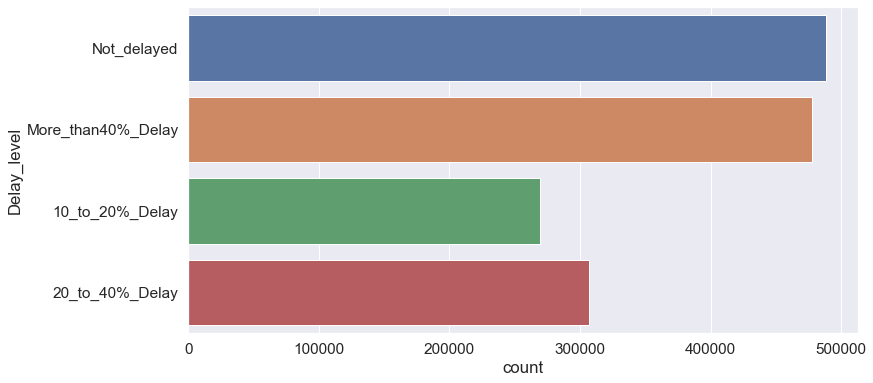

In [45]:
countplt, ax = plt.subplots(figsize = (12,6))
ax = sns.countplot(y='Delay_level', data=train)

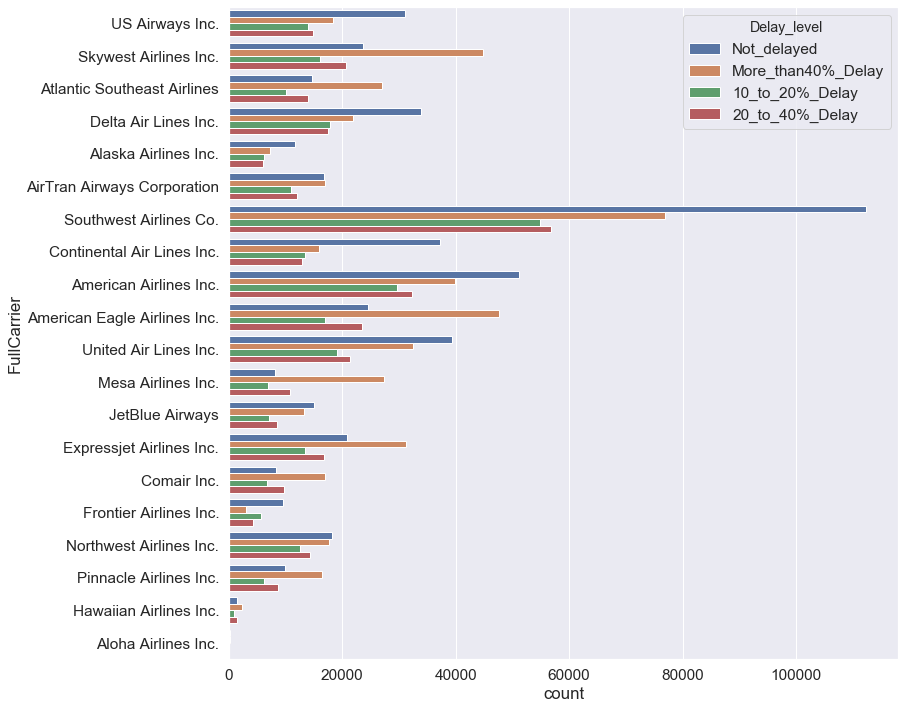

In [46]:
countplt, ax = plt.subplots(figsize = (12,12))
ax = sns.countplot(y='FullCarrier', hue='Delay_level', data=train)

### Creación de columna de Rangos horarios

In [47]:
def arr_time(x):

  if x >= 600 and x <= 659:
    return '0600-0659'
  elif x>=1400 and x<=1459:
    return '1400-1459'
  elif x>=1200 and x<=1259:
    return '1200-1259'
  elif x>=1500 and x<=1559:
    return '1500-1559'
  elif x>=1900 and x<=1959:
    return '1900-1959'
  elif x>=900 and x<=959:
    return '0900-0959'
  elif x>=1000 and x<=1059:
    return  '1000-1059'
  elif x>=2000 and x<=2059:
    return '2000-2059'
  elif x>=1300 and x<=1359:
    return '1300-1359'
  elif x>=1100 and x<=1159:
    return '1100-1159'
  elif x>=800 and x<=859:
    return '0800-0859'
  elif x>=2200 and x<=2259:
    return '2200-2259'
  elif x>=1600 and x<=1659:
    return '1600-1659'
  elif x>=1700 and x<=1759:
    return '1700-1759'
  elif x>=2100 and x<=2159:
    return '2100-2159'
  elif x>=700 and x<=759:
    return '0700-0759'
  elif x>=1800 and x<=1859:
    return '1800-1859'
  elif x>=1 and x<=559:
    return '0001-0559'
  elif x>=2300 and x<=2400:
    return '2300-2400'

In [48]:
train['ArrTime_Range'] = train['ArrTime'].str[:2] + train['ArrTime'].str[-2:]
train['DepTime_Range'] = train['DepTime'].str[:2] + train['DepTime'].str[-2:]

C:\Users\tomi_\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\tomi_\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [49]:
train['ArrTime_Range'] = train['ArrTime_Range'].astype('int')
train['ArrTime_Range'] = train['ArrTime_Range'].apply(lambda x :arr_time(x))

train['DepTime_Range'] = train['DepTime_Range'].astype('int')
train['DepTime_Range'] = train['DepTime_Range'].apply(lambda x :arr_time(x))

train.reset_index(inplace=True)
train.head()

C:\Users\tomi_\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\tomi_\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\tomi_\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

,index,DayOfWeek,FullCarrier,Origin,Dest,Cancelled,ArrDelay,CRSElapsedTime,DepDelay,ArrTime,DepTime,AirTime,Distance,AvgSpeed,10%_Delayed,ArrDelay_vs_CRSElapsedTime,Delay_level,ArrTime_Range,DepTime_Range
0,140013,4,US Airways Inc.,CLT,RSW,0,-4.0,118.0,10.0,23:53,22:09,87.0,600,413.79,0,-0.034,Not_delayed,2300-2400,2200-2259
1,950166,3,Skywest Airlines Inc.,SFO,MRY,0,100.0,46.0,103.0,21:53,21:10,21.0,77,220.00,1,2.174,More_than40%_Delay,2100-2159,2100-2159
2,383758,1,Atlantic Southeast Airlines,DSM,ATL,0,50.0,123.0,60.0,15:18,12:25,99.0,743,450.30,1,0.407,More_than40%_Delay,1500-1559,1200-1259
3,631800,4,Delta Air Lines Inc.,BDL,ATL,0,74.0,144.0,65.0,18:53,16:20,120.0,859,429.50,1,0.514,More_than40%_Delay,1800-1859,1600-1659
4,614256,1,Alaska Airlines Inc.,SEA,LAX,0,-2.0,160.0,14.0,09:08,06:44,124.0,954,461.61,0,-0.012,Not_delayed,0900-0959,0600-0659


### Estandarización de columnas numéricas

Columna AvgSpeed contiene 6 valores infinitos. Los reemplazo por NaN y luego los elimino. 

In [50]:
train.replace([np.inf, -np.inf], np.nan, inplace=True)

C:\Users\tomi_\Anaconda3\lib\site-packages\pandas\core\frame.py:4263: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [51]:
train.replace([np.inf, -np.inf], np.nan, inplace=True)
train = train.dropna(subset=['AvgSpeed'])

In [52]:
numeric_columns = ['ArrDelay', 'ArrDelay_vs_CRSElapsedTime', 'CRSElapsedTime', 'DepDelay', 'AirTime', 'Distance', 'AvgSpeed']

scaler = StandardScaler()

In [53]:
train[numeric_columns] = scaler.fit_transform(train[numeric_columns])

C:\Users\tomi_\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\tomi_\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


--

Chequeo de correcta transformación de variables

--

In [54]:
train[numeric_columns].head()

,ArrDelay,ArrDelay_vs_CRSElapsedTime,CRSElapsedTime,DepDelay,AirTime,Distance,AvgSpeed
0,-0.813406,-0.689538,-0.227650,-0.621157,-0.310255,-0.287766,0.165092
1,1.018342,2.813801,-1.238764,1.125044,-1.272228,-1.199353,-1.743096
2,0.137694,0.010178,-0.157434,0.317661,-0.135351,-0.038518,0.524594
3,0.560405,0.179950,0.137475,0.411543,0.170731,0.163670,0.319784
4,-0.778180,-0.654632,0.362167,-0.546051,0.229033,0.329255,0.635960


### Análisis descriptivo estadístico de variables estandarizadas

In [55]:
train[numeric_columns].describe()

,ArrDelay,ArrDelay_vs_CRSElapsedTime,CRSElapsedTime,DepDelay,AirTime,Distance,AvgSpeed
count,1.542690e+06,1.542690e+06,1.542690e+06,1.542690e+06,1.542690e+06,1.542690e+06,1.542690e+06
mean,-8.716529e-16,4.683144e-16,-4.917140e-16,-1.645447e-17,4.547340e-16,-1.738001e-16,6.131456e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.662767e+00,-7.813629e+00,-2.179662e+00,-6.962619e-01,-1.563735e+00,-1.314391e+00,-3.699729e+00
25%,-5.844376e-01,-5.245257e-01,-7.332069e-01,-5.836038e-01,-7.329405e-01,-7.444310e-01,-4.442202e-01
50%,-3.202432e-01,-3.039803e-01,-2.557364e-01,-3.582877e-01,-2.665293e-01,-2.773080e-01,6.751166e-02
75%,2.433715e-01,1.577369e-01,4.323829e-01,1.862264e-01,4.185121e-01,4.059465e-01,5.037195e-01
max,4.246164e+01,3.865088e+02,7.383791e+00,4.551233e+01,1.432340e+01,7.315184e+00,5.467169e+02


In [56]:
train.head()

,index,DayOfWeek,FullCarrier,Origin,Dest,Cancelled,ArrDelay,CRSElapsedTime,DepDelay,ArrTime,DepTime,AirTime,Distance,AvgSpeed,10%_Delayed,ArrDelay_vs_CRSElapsedTime,Delay_level,ArrTime_Range,DepTime_Range
0,140013,4,US Airways Inc.,CLT,RSW,0,-0.813406,-0.227650,-0.621157,23:53,22:09,-0.310255,-0.287766,0.165092,0,-0.689538,Not_delayed,2300-2400,2200-2259
1,950166,3,Skywest Airlines Inc.,SFO,MRY,0,1.018342,-1.238764,1.125044,21:53,21:10,-1.272228,-1.199353,-1.743096,1,2.813801,More_than40%_Delay,2100-2159,2100-2159
2,383758,1,Atlantic Southeast Airlines,DSM,ATL,0,0.137694,-0.157434,0.317661,15:18,12:25,-0.135351,-0.038518,0.524594,1,0.010178,More_than40%_Delay,1500-1559,1200-1259
3,631800,4,Delta Air Lines Inc.,BDL,ATL,0,0.560405,0.137475,0.411543,18:53,16:20,0.170731,0.163670,0.319784,1,0.179950,More_than40%_Delay,1800-1859,1600-1659
4,614256,1,Alaska Airlines Inc.,SEA,LAX,0,-0.778180,0.362167,-0.546051,09:08,06:44,0.229033,0.329255,0.635960,0,-0.654632,Not_delayed,0900-0959,0600-0659


### Exportación de fichero previo a transformación de variables Dummies

In [57]:
train.to_csv('Delayed_Flights_no_dummies_train.csv')

In [58]:
test.to_csv('Delayed_Flights_no_dummies_test.csv')

### Creando variables Dummies en base a posibles valores de "Delay_level"

In [59]:
train = pd.get_dummies(data=train, columns=['FullCarrier', 'Origin', 'Dest'])
train.head()

,index,DayOfWeek,Cancelled,ArrDelay,CRSElapsedTime,DepDelay,ArrTime,DepTime,AirTime,Distance,...,Dest_TYR,Dest_TYS,Dest_VLD,Dest_VPS,Dest_WRG,Dest_WYS,Dest_XNA,Dest_YAK,Dest_YKM,Dest_YUM
0,140013,4,0,-0.813406,-0.227650,-0.621157,23:53,22:09,-0.310255,-0.287766,...,0,0,0,0,0,0,0,0,0,0
1,950166,3,0,1.018342,-1.238764,1.125044,21:53,21:10,-1.272228,-1.199353,...,0,0,0,0,0,0,0,0,0,0
2,383758,1,0,0.137694,-0.157434,0.317661,15:18,12:25,-0.135351,-0.038518,...,0,0,0,0,0,0,0,0,0,0
3,631800,4,0,0.560405,0.137475,0.411543,18:53,16:20,0.170731,0.163670,...,0,0,0,0,0,0,0,0,0,0
4,614256,1,0,-0.778180,0.362167,-0.546051,09:08,06:44,0.229033,0.329255,...,0,0,0,0,0,0,0,0,0,0


### Resumen estadístico descriptivo de nuevas variables dummy

In [60]:
#delay_level_dummies = ['Delay_level_Not_delayed', 'Delay_level_10_to_20%_Delay', 'Delay_level_20_to_40%_Delay', 'Delay_level_More_than40%_Delay']

In [61]:
#train[delay_level_dummies].describe()

### Exporting Train and Test sets

In [62]:
train.to_csv('Delayed_Flights_train.csv')

In [63]:
test.to_csv('Delayed_Flights_test.csv')

In [64]:
len(train)

1542690